# seq2seq training with DafaFile datasets
Michael Nolan - 2020.09.11.3125

In [1]:
import aopy
import ecog_is2s

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from functools import partial

import os.path as path
import glob

In [2]:
# get data files and create datafile objects
data_path_root = 'E:\\aoLab\\Data\\WirelessData\\Goose_Multiscale_M1'
data_path_day = path.join(data_path_root,'180325')
data_file_list = glob.glob(path.join(data_path_day,'*\\*ECOG*clfp.dat'))
print(f'files found:\t{len(data_file_list)}')
print(f'files: {data_file_list}')
datafile_list = [aopy.data.DataFile(df) for df in data_file_list]


files found:	10
files: ['E:\\aoLab\\Data\\WirelessData\\Goose_Multiscale_M1\\180325\\001\\rec001.LM1_ECOG_3.clfp.dat', 'E:\\aoLab\\Data\\WirelessData\\Goose_Multiscale_M1\\180325\\002\\rec002.LM1_ECOG_3.clfp.dat', 'E:\\aoLab\\Data\\WirelessData\\Goose_Multiscale_M1\\180325\\010\\rec010.LM1_ECOG_3.clfp.dat', 'E:\\aoLab\\Data\\WirelessData\\Goose_Multiscale_M1\\180325\\008\\rec008.LM1_ECOG_3.clfp.dat', 'E:\\aoLab\\Data\\WirelessData\\Goose_Multiscale_M1\\180325\\009\\rec009.LM1_ECOG_3.clfp.dat', 'E:\\aoLab\\Data\\WirelessData\\Goose_Multiscale_M1\\180325\\005\\rec005.LM1_ECOG_3.clfp.dat', 'E:\\aoLab\\Data\\WirelessData\\Goose_Multiscale_M1\\180325\\004\\rec004.LM1_ECOG_3.clfp.dat', 'E:\\aoLab\\Data\\WirelessData\\Goose_Multiscale_M1\\180325\\003\\rec003.LM1_ECOG_3.clfp.dat', 'E:\\aoLab\\Data\\WirelessData\\Goose_Multiscale_M1\\180325\\007\\rec007.LM1_ECOG_3.clfp.dat', 'E:\\aoLab\\Data\\WirelessData\\Goose_Multiscale_M1\\180325\\006\\rec006.LM1_ECOG_3.clfp.dat']


In [3]:
# set time parameters - source, target and step lengths
src_t = 1.0
trg_t = 0.5
step_t = 0.5
scale_factor = 0.25
transform = partial(aopy.data.data_transform_normalize,scale_factor=scale_factor)
datafile_concat_dataset = aopy.data.DatafileConcatDataset([aopy.data.DatafileDataset(df,src_t,trg_t,step_t,transform=transform) for df in datafile_list])
srate = datafile_concat_dataset.srate

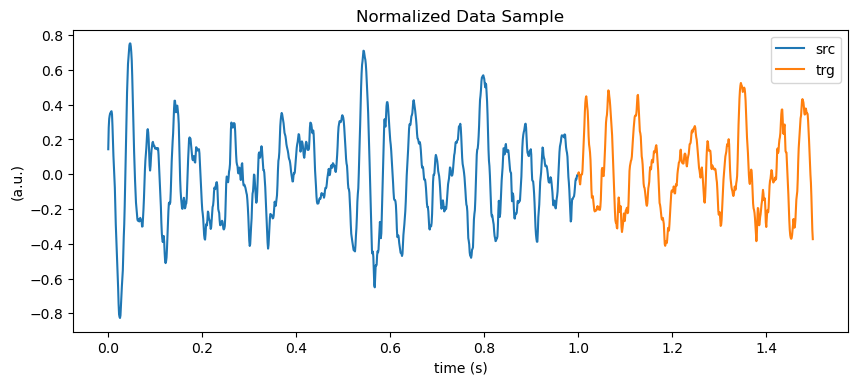

In [4]:
src,trg = datafile_concat_dataset.__getitem__(0)
src_time = np.arange(src.shape[-1])/srate
trg_time = np.arange(trg.shape[-1])/srate + src_t
plot_ch_idx = 11
f,ax = plt.subplots(1,1,dpi=100,figsize=(10,4))
ax.plot(src_time,src[plot_ch_idx,:],label='src')
ax.plot(trg_time,trg[plot_ch_idx,:],label='trg')
ax.set_xlabel('time (s)')
ax.set_ylabel('(a.u.)')
ax.set_title('Normalized Data Sample')
ax.legend(loc=0)

## Linear Methods - baselines for comparison
So: we have a data sampling interface that gives us access to the entire first day's data simultaneously. Those samples are normalized to be ~ in the range of \[-1, 1\].

Now that I have that, I can easily (!) test out some linear prediction models to get baseline prediction method performance measures. The first and most basic (really basic) of these is a sample-wise MSE estimate of one-step signal dynamics. Here's an implementation of that:

In [5]:
import tqdm
def mse_est(datafile_concat_dataset):
    n_sample = len(datafile_concat_dataset)
    fve = np.zeros((datafile_concat_dataset.n_ch,n_sample))
    for sample_idx in tqdm.tqdm(range(n_sample)):
        # get sample
        src, trg = datafile_concat_dataset.__getitem__(sample_idx)
        # estimate dynamics (MSE)
        X = src[:,:-1]
        Y = src[:,1:]
        A_hat = (Y @ X.T) @ np.linalg.inv(X @ X.T)
        # predict target activity
        out = np.zeros(trg.shape)
        out[:,0] = A_hat @ src[:,-1]
        for est_idx in range(1,trg.shape[-1]):
            out[:,est_idx] = A_hat @ out[:,est_idx-1]
        # measure error
        ss_err = np.var(trg-out, axis=-1)
        ss_trg = np.var(-trg.mean(axis=-1)[:,None] + trg, axis=-1)
        fve[:,sample_idx] = 1 - ss_err/ss_trg
        # # plot prediction
        # plt.plot(src_time,src[plot_ch_idx,:],label='src')
        # plt.plot(trg_time,trg[plot_ch_idx,:],label='trg')
        # plt.plot(trg_time,out[plot_ch_idx,:],label='out')
        # plt.ylim([-1,1])
        # plt.legend(loc=0)
        # plt.xlabel('time (s)')
        # plt.ylabel('(a.u.)')
        # plt.title(f'MSE Prediction (fve = {fve[plot_ch_idx]:0.2f})')
        # f = plt.gcf()
    return fve

fve_mse = mse_est(datafile_concat_dataset)

100%|██████████| 128610/128610 [11:00<00:00, 194.72it/s]


Text(0.5, 1.0, 'MSE FVE, single-trial estimate')

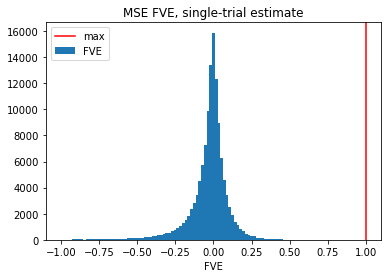

In [26]:
plt.hist(fve_mse[plot_ch_idx,fve_mse[plot_ch_idx,:]>-1.0],100,label='FVE')
plt.axvline(1.0,color='r',label='max')
plt.legend(loc=0)
plt.xlabel('FVE')
plt.title('MSE FVE, single-trial estimate')

...not great! Let's take a look at the best case:

Text(0.5, 1.0, 'Best MSE Prediction (fve = 0.97)')

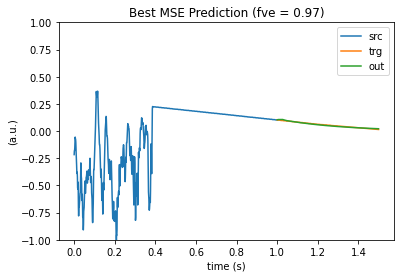

In [39]:
_best_sample_idx = np.nanargmax(fve_mse)
best_ch_idx = _best_sample_idx // len(datafile_concat_dataset)
best_sample_idx = _best_sample_idx % len(datafile_concat_dataset)
# get sample
src, trg = datafile_concat_dataset.__getitem__(best_sample_idx)
# estimate dynamics (MSE)
X = src[:,:-1]
Y = src[:,1:]
A_hat = (Y @ X.T) @ np.linalg.inv(X @ X.T)
# predict target activity
out = np.zeros(trg.shape)
out[:,0] = A_hat @ src[:,-1]
for est_idx in range(1,trg.shape[-1]):
    out[:,est_idx] = A_hat @ out[:,est_idx-1]
# measure error
ss_err = np.var(trg-out, axis=-1)
ss_trg = np.var(-trg.mean(axis=-1)[:,None] + trg, axis=-1)
# fve[:,sample_idx] = 1 - ss_err/ss_trg
# plot prediction
plt.plot(src_time,src[best_ch_idx,:],label='src')
plt.plot(trg_time,trg[best_ch_idx,:],label='trg')
plt.plot(trg_time,out[best_ch_idx,:],label='out')
plt.ylim([-1,1])
plt.legend(loc=0)
plt.xlabel('time (s)')
plt.ylabel('(a.u.)')
plt.title(f'Best MSE Prediction (fve = {fve_mse[best_ch_idx,best_sample_idx]:0.2f})')
# f = plt.gcf()